# Image Classification Using Transfer Learning with Food-101 Dataset

The purpose of this experiment is to utilize a transfer learning approach to classify images from the Food-101 dataset. A resnet50 architechture with weights pre-trained on ImageNet is utilized. In addition, various data transformations are utilized to augment the dataset which can result in improved model performance. This experiment demonstrates that a pretrained model with dataset transformations can result in state of the art performance with far fewer training epochs. The results from the experiment are documented in this notebook.

In [3]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import resnet50
from fastai.callbacks import CSVLogger

In [4]:
path = '/home/ubuntu/food_101/food-101'

In [5]:
# Standard Transformations from FastAI Library
tfms = get_transforms()

In [1]:
import warnings

# Fixes issues with PyTorch warning when loading data with databunch
# source: https://forums.fast.ai/t/warnings-when-trying-to-make-an-imagedatabunch/56323
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

### Loading Data

In [5]:
data = (ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch()
        .normalize(imagenet_stats)
       )

The dataset is loaded with the `fastai` DataBunch api. The training and validation dataset are split 80/20 by random. The images in the dataset are resized to 224 which is the same size of the images in ImageNet. The images are then normalized using the same normalization methods used on the ImageNet dataset.

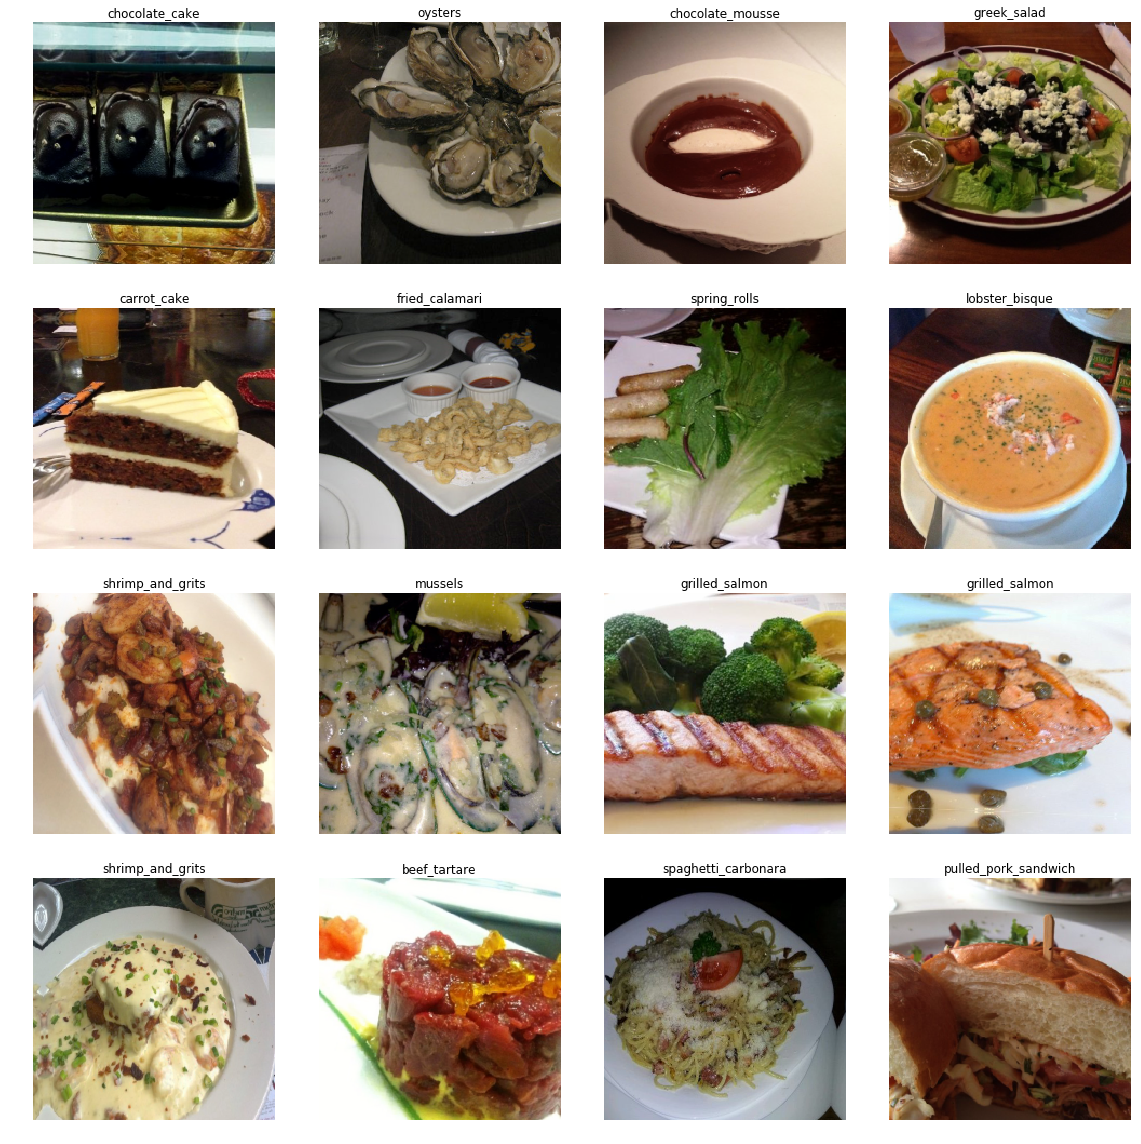

In [6]:
data.show_batch(rows=4)

The `show_bach` method provides a grid of images from the dataset resized and normalized to same specifications as ImageNet.

### Dataset Transformations

In [8]:
from pathlib import Path

In [11]:
img_path = Path(path)/'images/cheesecake/1001446.jpg'
def get_ex(): return open_image(img_path)

In [20]:
# Visualize transformations with plots_f
# source: https://docs.fast.ai/vision.transform.html#get_transforms
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

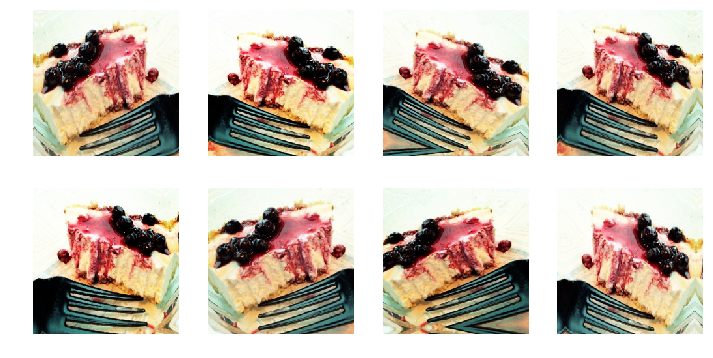

In [31]:
plots_f(2, 4, 12, 6, size=224)

The dataset transformations can be seen in the images above. These transformations are created using the standard `get_transforms` function in `fastai`. The transformations in `get_transforms` function flip the images vertically, can rotates the images, zoom in on the images, can create random lighting and constrast changes, and warp the images.

Note: More information regarding these transformations can be found in the `fastai` documentation [here](https://docs.fast.ai/vision.transform.html#get_transforms).

### Training the model

In [ ]:
learner = cnn_learner(data, resnet50, metrics=[accuracy, top_k_accuracy], callback_fns=[CSVLogger, ShowGraph])

The two metrics utilized are `accuracy` and `top_k_accuracy` with k=5.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


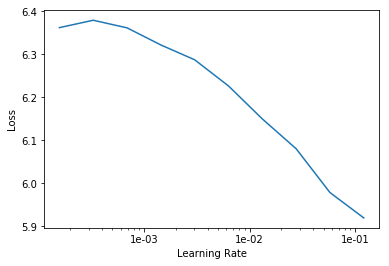

In [35]:
learner.lr_find(num_it=25)
learner.recorder.plot()

Before training the model, the `lr_find` function is used to find the optimal learning rate. Using the graph above, a learning rate of `1e-02` is utilized. The model the utilizes one cycle policy for training. In this form of learning, the learning rate gradually increases while the momentum is progressively decreased. At the middle of the training iterations, the process is reveresed and learning rate gradually decreases and the momentum is gradually increased. For this reason, `1e-02` is chosen and not the optimal learning rate from the graph above.

More information on one cycle policy can be found in the `fastai` documentation [here](https://docs.fast.ai/callbacks.one_cycle.html).

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.576521,1.350696,0.641683,0.874950,12:28
1,1.508817,1.216028,0.677327,0.894257,12:27
2,1.292330,1.053073,0.720990,0.911139,12:27
3,1.097035,0.948863,0.747376,0.922079,12:28
4,0.964386,0.920592,0.754554,0.925792,12:30


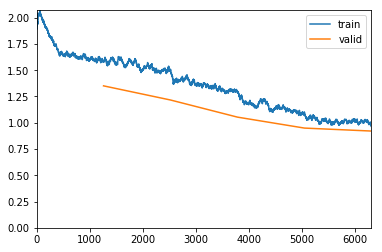

In [11]:
lr = 1e-2
learner.fit_one_cycle(5, slice(lr))

The model is trained for 5 epochs.

In [13]:
learner.save('food_101_epic_5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


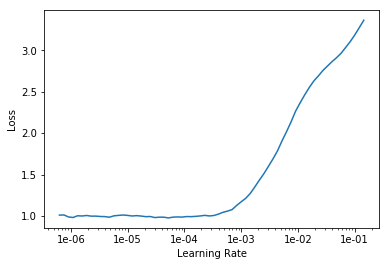

In [15]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

The model is unfrozen and a new learning rate range is determined. When using transfer learning, the top layer group of the model is frozen while the bottom layer is not - meaning the weights in the top layer remain unchanged. The top layer can be unfrozen for further training and this improves the generalization of the model. 

There is a discussion on the fastai [message board](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614/12) regarding this point.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.141070,1.010896,0.730792,0.915743,15:24
1,1.036875,0.937248,0.750644,0.925049,15:32
2,0.865055,0.795850,0.785792,0.939356,15:32
3,0.673000,0.712475,0.809554,0.948069,15:42
4,0.530637,0.693140,0.815990,0.949059,15:30


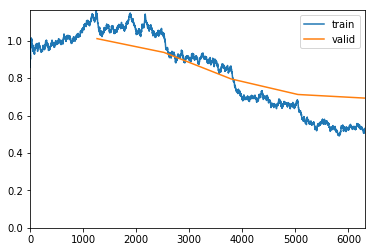

In [16]:
learner.fit_one_cycle(5, slice(1e-05, 1e-03))

In [17]:
learner.save('food_101_epic_10')

In [27]:
learner.load('food_101_epic_10');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.729282,0.543176,0.849455,0.966436,15:13
1,0.779707,0.609805,0.830792,0.960941,15:26
2,0.645895,0.573431,0.841931,0.963020,15:33
3,0.504492,0.509219,0.859901,0.969257,15:29
4,0.368027,0.495527,0.862525,0.969554,15:33


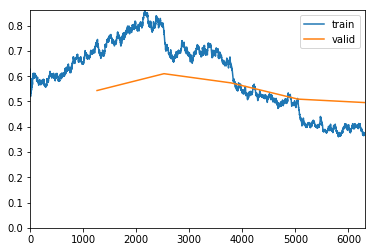

In [28]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-05, 1e-03))

In [29]:
learner.save('food_101_epic_15')

In [9]:
learner.load('food_101_epic_15');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.557747,0.370596,0.896436,0.981139,15:28
1,0.682452,0.479461,0.868465,0.973416,15:27
2,0.540994,0.434246,0.881139,0.976782,15:23
3,0.378983,0.379209,0.897129,0.980148,15:25
4,0.286522,0.363791,0.902178,0.980545,15:28


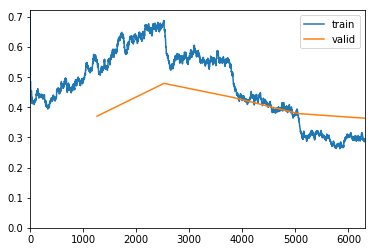

In [10]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-05, 1e-03))

In [11]:
learner.save('food_101_epic_20');

In [8]:
learner.load('food_101_epic_20');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.445799,0.292954,0.917228,0.987574,15:50
1,0.590249,0.408945,0.884109,0.980148,16:12
2,0.453114,0.360919,0.896485,0.981584,16:21
3,0.298390,0.304751,0.911238,0.984901,16:19
4,0.222754,0.288013,0.917673,0.986040,16:15


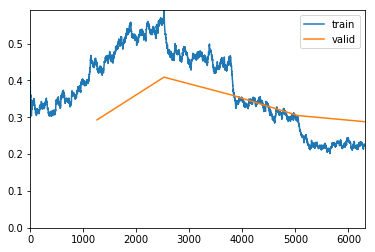

In [9]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-05, 1e-03))

In [10]:
learner.save('food_101_epic_25');

After training for 25 epochs, the accuracy score is 91.7% on the validation dataset.

### Training on Larger Image File

After training for 25 epochs, additional training on larger image files was attempted.

In [5]:
data_large = (ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms=tfms, size=512)
        .databunch(bs=16)
        .normalize(imagenet_stats)
       )

In order for the larger image files to fit in GPU memory, the batch size had to be reduced to 16.

In [13]:
learner = cnn_learner(data_large, resnet50, metrics=[accuracy, top_k_accuracy], callback_fns=[CSVLogger, ShowGraph])
learner.load('food_101_epic_20');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


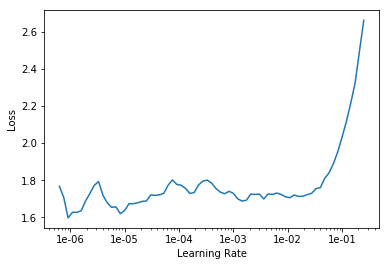

In [14]:
learner.lr_find()
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.728681,1.418964,0.630594,0.869851,1:10:10
1,1.914409,10.068954,0.643218,0.865545,1:10:17
2,1.372301,32.534534,0.710941,0.900792,1:10:45
3,0.916545,8.488615,0.786386,0.930149,1:10:37
4,0.739229,4.062324,0.817624,0.943317,1:10:51


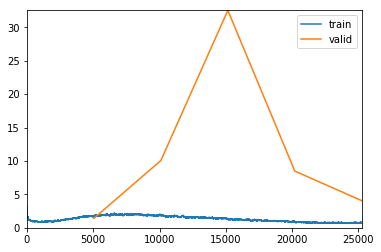

In [15]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-05, 1e-02))

In [ ]:
learner.save('food_101_large_epic_25');

In [6]:
learner = cnn_learner(data_large, resnet50, metrics=[accuracy, top_k_accuracy], callback_fns=[CSVLogger, ShowGraph])
learner.load('food_101_large_epic_25');

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.195457,40.094398,0.740842,0.908020,1:12:00
1,1.478922,27.889221,0.699951,0.889852,1:12:52
2,1.156472,36.179771,0.730000,0.899505,1:13:10
3,0.789913,6.427996,0.818168,0.940297,1:12:15
4,0.646557,1.875685,0.835792,0.954554,1:13:40


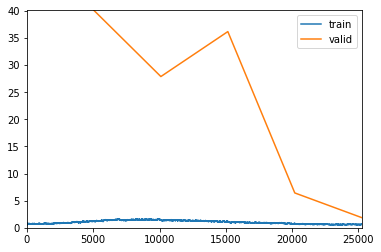

In [7]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-05, 1e-02))

In [8]:
learner.save('food_101_large_epic_30');

From the results above, it appears additional training on larger image files did not improve the model.

### Conclusion

This experiment demonstrated that transfer learning can be used for classification tasks and can created good results with fewer training iterations then a non-transfer learning approach. A [previous study](https://arxiv.org/pdf/1612.06543.pdf) with this dataset has resulted in a lower accuracy score with a greater number of epochs for training using a non-transfer learning approach.

It should be noted that in future work, more data transformations could be explored. By creating additional augmentations, the model accuracy could be further improved.